In [19]:
%%writefile model/data_setup.py
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from pathlib import Path
"""
Contain for setting updata with full func to create dataloader
"""

def create_dataloader(
                    train_transform: transforms.Compose,
                    val_transform: transforms.Compose,
                    test_transform: transforms.Compose,
                    **kwargs,
                ):
    
    train_path = Path(kwargs['dataset']['train'])
    val_path = Path(kwargs['dataset']['val'])
    test_path = Path(kwargs['dataset']['test'])
    
    num_workers = 6
    
    train_data = ImageFolder(
        root= train_path,
        transform= train_transform
    )
    
    val_data = ImageFolder(
        root= val_path,
        transform= val_transform
    )

    test_data = ImageFolder(
        root= test_path,
        transform= test_transform
    )
    
    train_dataloader = DataLoader(
        dataset= train_data,
        batch_size= kwargs['dataset']['batch_size'],
        num_workers=num_workers,
        pin_memory= True,
        persistent_workers= True,
        shuffle= True
    )
    
    val_dataloader = DataLoader(
        dataset= val_data,
        batch_size= kwargs['dataset']['batch_size'],
        num_workers=num_workers,
        pin_memory= True,
        persistent_workers= True,
        shuffle= False
    )

    test_dataloader = DataLoader(
        dataset= test_data,
        batch_size= kwargs['dataset']['batch_size'],
        shuffle= False
    )
    class_names = train_data.classes
    return train_dataloader, val_dataloader, test_dataloader, class_names

Overwriting model/data_setup.py


In [76]:
# %%writefile model/model_builder.py
import torch
from torch import nn
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights

from pathlib import Path
import json

def efficientnet_b3_model(class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    info_data = None
    if pretrain_model_path is None:
        weights = EfficientNet_B3_Weights.DEFAULT
        model = efficientnet_b3(weights= weights).to(device)
        
        features= model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
        model = model.to(device)
        
    else:
        pretrain_model_path = Path(pretrain_model_path)

        with open(pretrain_model_path / 'info.json', 'r') as f:
            info_data = json.load(f)
        
        model = efficientnet_b3().to(device)
        
        features= model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
        
        model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
        model = model.to(device)
        
    return model, info_data


def resnet50_model(class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    info_data = None
    if pretrain_model_path is None:
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights= weights).to(device)
        features= model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
        model = model.to(device)
        
    else:
        pretrain_model_path = Path(pretrain_model_path)

        with open(pretrain_model_path / 'info.json', 'r') as f:
            info_data = json.load(f)
        
        model = resnet50().to(device)
        model.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=len(info_data['class_names']), bias=True)
        )
        model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
        model = model.to(device)
        
    return model, info_data

def resnet18_model(class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    info_data = None
    if pretrain_model_path is None:
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights= weights).to(device)
        features= model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
        model = model.to(device)
        
    else:
        pretrain_model_path = Path(pretrain_model_path)

        with open(pretrain_model_path / 'info.json', 'r') as f:
            info_data = json.load(f)
        
        model = resnet18().to(device)
        features= model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features=features, out_features=len(info_data['class_names']), bias=True)
        )
        model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
        model = model.to(device)
        
    return model, info_data

In [3]:
%%writefile model/utils.py
import os
from pathlib import Path
import torch
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def plot_loss_curves(results: dict[str, list[float]]):
    train_loss = results['train_loss']
    val_loss = results['val_loss']
    train_accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    return plt

def plot_confmat(class_names, df_test_results, threshold= .90):
    over_threshold = df_test_results[df_test_results['scores'] >= threshold]
    under_threshold = df_test_results[df_test_results['scores'] < threshold]

    y_true = over_threshold['targets']
    y_pred = over_threshold['preds']
    len_known = len(under_threshold)
    
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    accurancy = round(len(over_threshold) / len(df_test_results), 4)
    
    table = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    plt.figure(figsize=(7.5, 5))
    sns.heatmap(table, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    
    plt.text(x=12.5, y=0.5, s= f'Detected: {accurancy}')
    plt.text(x=12.5, y=1.5, s= f'Threshold: {threshold}')
    plt.text(x=12.5, y=2, s= f'Unknown: {len_known}')
    plt.text(x=12.5, y=2.5, s= f'Metric:')
    plt.text(x=12.5, y=3, s= f' - Precision: {round(precision, 3)}')
    plt.text(x=12.5, y=3.5, s= f' - Recall: {round(recall, 3)}')
    plt.text(x=12.5, y=4, s= f' - F1 score: {round(f1, 3)}')

    plt.text(x=12.5, y=5, s= f'Class names:')
    for i, class_name in enumerate(class_names):
        plt.text(x=12.5, y=5.5+(i/2), s= f' {i}. {class_name[:15]}{"..." if len(class_name) > 15 else ""}')

    plt.tight_layout()
    return plt

def plot_save_model(model: torch.nn.Module,
               results: dict[str, list[float]],
               class_names: list,
               device: str,
               is_save: bool,
               **kwargs):

    df_test_results = pd.DataFrame(results['test_results'])
    threshold = kwargs['test_para']['threshold']
    
    if is_save:
        target_dir = Path('runs/classify/')
        target_dir.mkdir(parents=True, exist_ok=True)
        
        model_name = 'model.pth'
        graph_loss_name = 'loss_acc.jpg'
        graph_confmat_name = 'confusion_matrix.jpg'
        info_file_name = 'info.json'
        
        train_paths = os.listdir(target_dir)
        
        i = 0
        
        while True:
            train_path = f'train{i}'
            if train_path not in train_paths:
                break
            else:
                i += 1
    
        target_dir = target_dir / train_path
        
        target_dir_path = Path(target_dir)
        target_dir_path.mkdir(parents=True,exist_ok=True)
        
        model_save_path = target_dir_path / model_name
        graph_loss_save_path = target_dir_path / graph_loss_name
        graph_confmat_save_path = target_dir_path / graph_confmat_name
        info_save_path = target_dir_path / info_file_name

        print(f"[INFO] Saving model to: {target_dir}")
        
        info_data = {
            "class_names" : class_names,
            "results" : results
        }
        
        with open(info_save_path, 'w') as f:
            json.dump(info_data, f, indent=4)
    
    graph_loss = plot_loss_curves(results)
    if is_save: graph_loss.savefig(graph_loss_save_path)
        
    graph_confmat = plot_confmat(class_names=class_names, df_test_results= df_test_results, threshold= threshold)
    if is_save: graph_confmat.savefig(graph_confmat_save_path)
    
    if is_save: torch.save(obj=model.state_dict(), f=model_save_path)

def save_checkpoint(model: torch.nn.Module, num: int):
    target_path = Path('runs/classify/')
    target_path.mkdir(parents=True, exist_ok=True)

    checkpoint_dir = target_path / 'checkpoints'
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    checkpoint_names = os.listdir(checkpoint_dir)
    
    checkpoint_name = f'.checkpoint_{num}.pth'

    checkpoint_path = checkpoint_dir / checkpoint_name
    torch.save(obj=model.state_dict(), f=checkpoint_path)

    print(f'Save checkpoint to {checkpoint_path}')

Overwriting model/utils.py


In [2]:
%%writefile model/engine.py
import torch
from torchmetrics import Accuracy
from tqdm.auto import tqdm
from model.utils import save_checkpoint

def __train(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_func: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            mectric_func: Accuracy,
            verbose: bool,
            device: str):
    
    train_loss = 0
    train_acc = 0
    
    model.train()

    for _, (X, y) in enumerate(tqdm(dataloader, desc= '-----Train', disable= (not verbose))):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_func(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)
        train_acc += mectric_func(y_pred, y).item()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

def __val(model: torch.nn.Module,
           dataloader: torch.utils.data.DataLoader,
           loss_func: torch.nn.Module,
           mectric_func: Accuracy,
           verbose: bool,
           device: str):

    val_loss = 0
    val_acc = 0
    
    model.eval()
    
    with torch.inference_mode():
        for _, (X, y) in enumerate(tqdm(dataloader, desc= '-------Val', disable= (not verbose))):
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            loss = loss_func(y_pred, y)
            
            val_loss += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)
            val_acc += mectric_func(y_pred, y).item()

        val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        
    return val_loss, val_acc

def __test(model: torch.nn.Module,
           dataloader: torch.utils.data.DataLoader,
           verbose: bool,
           device: str):
    
    model.eval()
    target = torch.tensor([]).to(device)
    preds = torch.tensor([]).to(device)
    score = torch.tensor([]).to(device)
    
    with torch.inference_mode():
        for _, (X, y) in enumerate(tqdm(dataloader, desc= '------Test', disable= (not verbose))):
            X, y = X.to(device), y.to(device)

            
            y_pred = model(X)

            y_probs = torch.softmax(y_pred, dim= 1)
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)

            y_pred_scores = torch.max(y_probs, dim= 1)[0]

            target = torch.cat((target, y), dim= 0)
            preds = torch.cat((preds, y_pred_class), dim= 0)
            score = torch.cat((score, y_pred_scores), dim= 0)

    test_results = {
        'preds' : preds.tolist(),
        'targets' : target.tolist(),
        'scores' : score.tolist()
    }

    return test_results

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          loss_func: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
          mectric_funcs: Accuracy,
          epochs: int,
          info_data: list,
          save_checkpoint_freq: int,
          verbose: bool,
          device: str):
    
    temp_model_state_dict = model.state_dict()
    
    if info_data is None:
        results = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_results' : {}
        }
    else:
        results = info_data['results']
    
    if epochs <= 0: return results
        
    try:
        torch.manual_seed(42) 
        torch.cuda.manual_seed(42)
        for epoch in tqdm(range(epochs), desc= 'Training', disable=(not verbose)):
            if (verbose):
                print(f"\n\nEpoch: {epoch+1:2} ------------")
            train_loss, train_acc = __train(model=model,
                                            dataloader=train_dataloader,
                                            loss_func=loss_func,
                                            optimizer=optimizer,
                                            mectric_func=mectric_funcs,
                                            verbose= verbose,
                                            device= device)
            lr_scheduler.step()
            val_loss, val_acc = __val(model=model,
                                    dataloader=val_dataloader,
                                    loss_func=loss_func,
                                    mectric_func=mectric_funcs,
                                    verbose= verbose,
                                    device= device)
            
            print(f"Epoch: {epoch+1:2} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc*100:.4f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc*100:.4f}")
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["val_loss"].append(val_loss)
            results["val_acc"].append(val_acc)
    
            if (save_checkpoint_freq != 0) and ((epoch+1) % save_checkpoint_freq == 0):
                save_checkpoint(model= model, num= int((epoch+1) / save_checkpoint_freq))
                
            temp_model_state_dict = model.state_dict()
    except KeyboardInterrupt:
        print('\nStop trainning')
        model.load_state_dict(temp_model_state_dict)
   
    print('\n\n')
    
    return results
    
def test(model: torch.nn.Module,
          test_dataloader: torch.utils.data.DataLoader,
          results: dict,
          verbose: bool,
          device: str):
    
    results["test_results"] = __test(model=model,
                                     dataloader=test_dataloader,
                                     verbose= verbose,
                                     device= device)
    return results

Overwriting model/engine.py


In [12]:
# %%writefile model/train.py
import torch
from torch import nn
from torchvision import transforms

from pathlib import Path
from torchmetrics import Accuracy, ConfusionMatrix

from model.data_setup import create_dataloader
from model.engine import train, test
from model.utils import save_model
from model.model_builder import resnet50_model
from model.model_builder import resnet18_model
from model.model_builder import efficientnet_b3_model

def run(**kwargs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: '{device}'")
    
    train_transforms_data = transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5)),
        transforms.transforms.ColorJitter(brightness= [0.8, 1.2], contrast= [0.8, 1.2]),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])
    
    val_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])

    test_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])
    
    train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloader(train_transform=train_transforms_data,
                                                                                      val_transform=val_transforms_data,
                                                                                      test_transform=test_transforms_data,
                                                                                      **kwargs)


    # model, info_data = resnet50_model(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    model, info_data = resnet18_model(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    # model, info_data = efficientnet_b3_model(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    
    loss_func = nn.CrossEntropyLoss()

    lr = kwargs['train_para']['optimize']['learning_rate']
    momentum = kwargs['train_para']['optimize']['momentum']
    weight_decay = kwargs['train_para']['optimize']['weight_decay']
    optimizer = torch.optim.SGD(params= model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(params= model.parameters(), lr= kwargs['train_para']['learning_rate'], weight_decay= 0.0001)
    
    accur = Accuracy(task='multiclass', num_classes= len(class_names)).to(device)

    step_size = kwargs['train_para']['lr_scheduler']['step_size']
    gamma = kwargs['train_para']['lr_scheduler']['gamma']
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size= step_size,
        gamma= gamma
    )

    epochs= kwargs['train_para']['epochs']
    save_checkpoint_freq= kwargs['train_para']['save_checkpoint_freq']
    verbose= kwargs['train_para']['verbose']
    
    results = train(
            model= model,
            train_dataloader= train_dataloader,
            val_dataloader= val_dataloader,
            loss_func= loss_func,
            optimizer= optimizer,
            lr_scheduler= lr_scheduler,
            mectric_funcs= accur,
            epochs= epochs,
            info_data = info_data,
            save_checkpoint_freq= save_checkpoint_freq,
            verbose= verbose,
            device= device,
    )

    results = test(model=model,
                  test_dataloader=test_dataloader,
                  results=results,
                  verbose= verbose,
                  device= device)
    
    save_model(model= model, results= results, class_names= class_names, device= device, **kwargs)

In [48]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': 32,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 20,
            'optimize' : {
                'learning_rate': 0.004,
                'momentum': 0.9,
                'weight_decay': 0.0001,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 0.5,
            },
            'save_checkpoint_freq' : 0,
            'verbose': True
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

NameError: name 'run' is not defined

In [2]:
# import os
# from pathlib import Path
# import random

# def rename_class(path):
#     class_names = os.listdir(path)

#     for class_name in class_names:
#         new_name = class_name.split('___')[1].replace(' ', '_')
#         os.rename(path / class_name, path / new_name)
#         # print(path / new_name)

# def rename_img(path):
#     class_names = os.listdir(path)

#     for class_name in class_names:
#         img_names = os.listdir(path / class_name)
#         for img_name in img_names:
#             extension = img_name[-4:]
#             img_path = path / class_name / img_name
#             new_img_path = path / class_name / (str(random.random())[2:] + extension)

#             os.rename(img_path, new_img_path)
#             # break
# # if __name__ == '__main__':
# datasets_path = Path('./datasets/tomato_raw')
# rename_class(datasets_path / 'train')
# rename_class(datasets_path / 'val')

# rename_img(datasets_path / 'train')
# rename_img(datasets_path / 'val')


In [ ]:
# import os
# import glob
# from pathlib import Path
# import random
# import shutil

# os.rename('./datasets/tomato/val/', './datasets/tomato/test')

# root = Path('./datasets/tomato/train/')
# target_path = Path('./datasets/tomato/val')

# target_path.mkdir(parents=True, exist_ok=True)
# class_names = os.listdir(root)

# for class_name in class_names:
#     img_names = os.listdir(root / class_name)
#     random_imgs = random.choices(img_names, k=200)
    
#     target = target_path / class_name
#     target.mkdir(parents=True, exist_ok=True)

#     random.shuffle(random_imgs)
    
#     for i in range(200):
#         random_img = img_names[i]

#         src = root / class_name / random_img
#         des = target / random_img
        
#         shutil.move(src, des)

In [5]:
import json

with open('./runs/classify/train3/info.json', 'r') as f:
            info_data = json.load(f)

In [6]:
y_true= info_data['results']['test_results']['target']
y_pred=info_data['results']['test_results']['preds']
class_names=info_data['class_names']

<module 'matplotlib.pyplot' from 'C:\\Users\\tranq\\AppData\\Local\\miniconda3\\envs\\Leaf_based_project\\Lib\\site-packages\\matplotlib\\pyplot.py'>

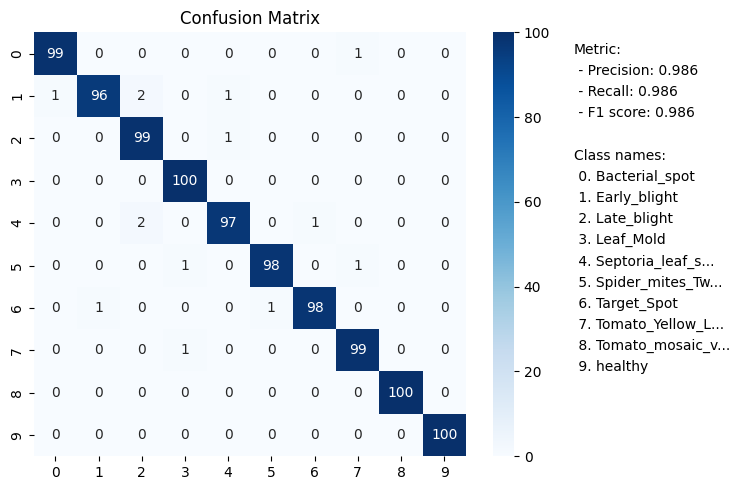

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def plot_confmat(class_names, y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    table = confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.figure(figsize=(7.5, 5))
    sns.heatmap(table, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.text(x=12.5, y=0.5, s= f'Metric:')
    plt.text(x=12.5, y=1, s= f' - Precision: {round(precision, 3)}')
    plt.text(x=12.5, y=1.5, s= f' - Recall: {round(recall, 3)}')
    plt.text(x=12.5, y=2, s= f' - F1 score: {round(f1, 3)}')

    plt.text(x=12.5, y=3, s= f'Class names:')
    for i, class_name in enumerate(class_names):
        plt.text(x=12.5, y=3.5+(i/2), s= f' {i}. {class_name[:15]}{"..." if len(class_name) > 15 else ""}')

    plt.tight_layout()
    return plt

plot_confmat(class_names, y_true, y_pred)
